This notebook performs the construction of the Markov State Model for the alanine dipeptide system. To manage time constraints, we eliminate two steps here: cross-validation to determine the hyperparameters to construct microstate-MSM and boostrapping to validate microstate-MSM.

In [17]:
# @title Install packages and download the necessary files
!pip install msmbuilder2022
!pip install numpy==1.23.5
!pip install matplotlib

!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/IGME/igme.py

!curl -L https://uwmadison.box.com/shared/static/o8f04vg9lso1iikctkt8b074rr0u63on --output ala.tar.gz
!curl -L https://uwmadison.box.com/shared/static/gvyxw3xsi8au4a0yb457y3arl4mmrjk1 --output ala.pdb

!mkdir xtc
!tar xzvf ala.tar.gz -C xtc
!rm ala.tar.gz

--2024-08-07 03:06:42--  https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/quasi-MSM/qmsm.py [following]
--2024-08-07 03:06:42--  https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/quasi-MSM/qmsm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12116 (12K) [text/plain]
Saving to: ‘qmsm.py.2’

qmsm.py.2           100%[===================>]  11.83K  --.-KB/s    in 0s      

2024-08-07 03:06:42 (70.5 MB/s) - ‘qmsm.py.2’ saved [12116/12116]

--2024-08-07 03:06:42--  https://github.com/xu

In [18]:
# @title Import necessary packages
import sys
import numpy as np
import mdtraj as md
from matplotlib import pyplot as plt

from msmbuilder.dataset import dataset
from msmbuilder.featurizer import DihedralFeaturizer, AtomPairsFeaturizer
from msmbuilder.decomposition import tICA
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import KMeans, MiniBatchKMeans, KCenters
from msmbuilder.lumping import PCCAPlus

from igme import IGME
from qmsm import QuasiMSM, MSM

import itertools

In [19]:
# @title Featurization: load trajectoris and extract the features

# Generate the pairs between heavy atoms
topfile = md.load("ala.pdb")
heavy_atom_idx = topfile.topology.select('not element H')
with open('heavy_atom_pairs_list.txt', 'w') as file:
  for pair in itertools.combinations(heavy_atom_idx, 2):
    file.write(f"{pair[0]} {pair[1]}\n")
atom_pair_list = np.loadtxt('heavy_atom_pairs_list.txt')
print("%d atom pairs are generated" % (len(atom_pair_list)))

# Atom-Pairs Featurization
xyz = dataset("./xtc/*.xtc", topology = 'ala.pdb', stride=1) # Saving interval: 0.1 ps
featurizer = AtomPairsFeaturizer(atom_pair_list)
ftrajs = featurizer.fit_transform(xyz)

print(f"The number of trajectoris: {len(ftrajs)} ")
print(f"The number of features: {ftrajs[0].shape[1]} ")
print(f"The number of frames: {len(np.concatenate(ftrajs))}")


45 atom pairs are generated
The number of trajectoris: 100 
The number of features: 45 
The number of frames: 1000100


In [20]:
# @title tICA: dimensionality reduction

# Use tICA for dimensionality reduction
tica = tICA(n_components=3, lag_time=2, kinetic_mapping=True)
tica_trajs = tica.fit_transform(ftrajs)
'''
Users can adjust these parameters in a demand-driven way:

n_components: int
    Number of collective variables (tICs) to generate
lag_time: int
    Delay time forward in the input data, in the unit of a saving interval.
    The time-lagged correlations is computed between datas X[t] and X[t+lag_time].
kinetic_mapping: bool
    If True, weigh the projections by the tICA eigenvalues, yielding kinetic distances.
'''

print("The dimension of the featurized trajectories is: %d"%ftrajs[0].shape[1])
print("The dimension of the trajectories after tICA is: %d"%tica_trajs[0].shape[1])

The dimension of the featurized trajectories is: 45
The dimension of the trajectories after tICA is: 3


In [21]:
# @title K-Centers: geometric clustering
cluster = KCenters(n_clusters=800, random_state=42)
clustered_trajs = cluster.fit_transform(tica_trajs)
'''
Users can adjust these parameters in a demand-driven way:

n_clusters: int
    The number of clusters to form.
random_state:
    The generator used to initialize the centers. Not necessary.
'''

print("The trajectories are transformed as transitions between states:")
print(clustered_trajs[0])

# The cluster centers for K-Centers are interpretable.
print("\nThe coordinates of the centers in the tIC-space are")
print(cluster.cluster_centers_)

The trajectories are transformed as transitions between states:
[120 568 383 ... 367 546 577]

The coordinates of the centers in the tIC-space are
[[ 1.23104552 -0.24083684  0.18117237]
 [ 1.16113447  5.88167916  0.17249821]
 [-0.44623361  2.87460486  0.24755254]
 ...
 [ 0.03602072 -0.45848791  0.13668646]
 [ 1.64524257  4.52827451 -0.49634451]
 [-0.51297312  1.25149043  0.88867415]]


In [22]:
# @title Construct the microstate-MSM
# at lag time = 10 ps
'''
We eliminate the validation of microstate-MSM due to time restrictions.
More details can be found on GitHub: https://github.com/xuhuihuang/GME_tutorials
'''
msm = MarkovStateModel(n_timescales=10, lag_time=10, ergodic_cutoff='off',
                       reversible_type='transpose', verbose=False)
msm.fit(clustered_trajs)
'''
Users can adjust these parameters in a demand-driven way:

lag_time: int
    The lag time of the model, in the unit of a saving interval.
n_timescales: int
    The number of dynamical timescales to calculate.
reversible_type: {'mle', 'transpose'}
    Method by which the reversibility of the transition matrix is enforced.
    'mle' uses a maximum likelihood method.
    'transpose' uses direct symmetrization of the expected number of counts.
ergodic_cutoff: float or {'on', 'off'}
    Ergodicity is determined by ensuring that each state is accessible from
    each other state via one or more paths involving edges with a number
    of observed directed counts greater than or equal to ``ergodic_cutoff``.
    By setting ``ergodic_cutoff`` to 0 or 'off', this trimming is turned off.
    Setting it to 'on' sets the cutoff to the minimal possible count value.
sliding_window : bool
    If True (the default setting), count transitions using a window of length lag_time,
    which is slid along the sequences one unit at a time. This method yields
    transitions that contain more data but cannot be assumed to be statistically independent.
    If False, the sequences are simply subsampled at an interval of ``lag_time``.
'''

# Attributes
micro_TCM = msm.countsmat_ # TCM
micro_TPM = msm.transmat_ # TPM
micro_population = msm.populations_ # Stationary Population Density
micro_timescales = msm.timescales_ # The ITS for the top modes, in the unit of a saving interval

delta_t = 1 # in unit of ps
print("The timescales of the top 10 modes for the microstate model are")
print(micro_timescales * delta_t)

The timescales of the top 10 modes for the microstate model are
[1153.33855764   60.63574808   20.45377481    7.43738656    7.40152653
    6.11424741    5.91220567    5.81967583    5.49010404    5.32585372]


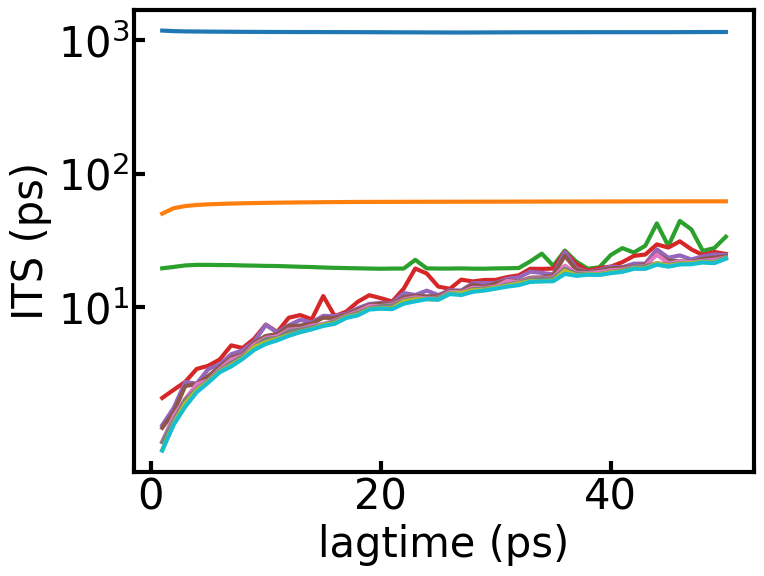

In [28]:
lagtime = np.arange(1, 51)
micro_ITS = np.zeros((len(lagtime), 10))
for i in range(len(lagtime)):
  msm = MarkovStateModel(n_timescales=10, lag_time=lagtime[i], ergodic_cutoff='off',
                         reversible_type='transpose',
                         verbose=False)
  msm.fit(clustered_trajs)
  micro_ITS[i] = msm.timescales_

# ITS test
plt.rcParams['font.size'] = 30
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    ax.plot(lagtime, np.log10(micro_ITS[:,i]), linewidth=3)

plt.yticks([1,2,3], labels=['$10^1$', '$10^2$','$10^3$'])
plt.xlabel('lagtime (ps)')
plt.ylabel('ITS (ps)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
for spine in ax.spines.values():
    spine.set_linewidth(3)
# fig.legend(loc='center right', bbox_to_anchor=(1.28, 0.5))
# plt.savefig('./png/ITS_bt.png', dpi=900, bbox_inches='tight')
plt.show()

In [ ]:
# @title PCCA+: Kinetic lumping
n_macro = 4
msm = MarkovStateModel(n_timescales=10, lag_time=1, reversible_type='transpose',
                       verbose=False, ergodic_cutoff='off')
msm.fit(clustered_trajs)
pcca = PCCAPlus.from_msm(msm, n_macrostates=n_macro)
lumped_trajs = pcca.fit_transform(clustered_trajs)
'''
Users can adjust these parameters in a demand-driven way:

n_macrostates: int
    The number of the metastable states.
'''

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Optimization terminated successfully.
         Current function value: -3.905211
         Iterations: 27
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -3.905211
         Iterations: 27
         Function evaluations: 107


'\nUsers can adjust these parameters in a demand-driven way:\n\nn_macrostates: int\n    The number of the metastable states.\n'

In [ ]:
# @title Use transpose method to get the symmetrized macrostate TPM
def generate_TPM(trajs, lagtime, n_macro):
    # Users can adjust the setting of the MarkovStateModel
    TPM = np.zeros((len(lagtime), n_macro, n_macro))
    for i in range(len(lagtime)):
        msm_macro = MarkovStateModel(n_timescales=3, lag_time=lagtime[i],
                                     ergodic_cutoff='off',
                                     reversible_type='transpose',
                                     verbose=False)
        msm_macro.fit(trajs)
        TPM[i] = np.array(msm_macro.transmat_)
    return TPM

delta_t = 1 # in unit of ps
n_macro = 4 # number of macrostates
TPM = generate_TPM(trajs = lumped_trajs, lagtime = np.arange(1, 51), n_macro = n_macro)
print(TPM.shape)

(50, 4, 4)


In [ ]:
# @title Generate the bootstrapping TPM
'''
can be generated (it takes time) or downloaded from github
'''
# num_runs = 50
# num_samples_per_run = 100
# lagtime = np.arange(1, 501)
# bootstrap_TPM = np.zeros((num_runs, len(lagtime), n_macro, n_macro))
# for i in range(num_runs):
#     bootstrap_indices = np.random.choice(range(len(lumped_trajs)),
#                                          size=num_samples_per_run, replace=True)
#     bootstrap_trajs = [lumped_trajs[i] for i in bootstrap_indices]
#     bootstrap_TPM[i] = generate_TPM(bootstrap_trajs, lagtime=lagtime, n_macro=n_macro)
#     print('Run {} is complete'.format(i))

!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/alanine_dipeptide/MacroGME/bootstrap_TPM.npy
bootstrap_TPM = np.load("bootstrap_TPM.npy")

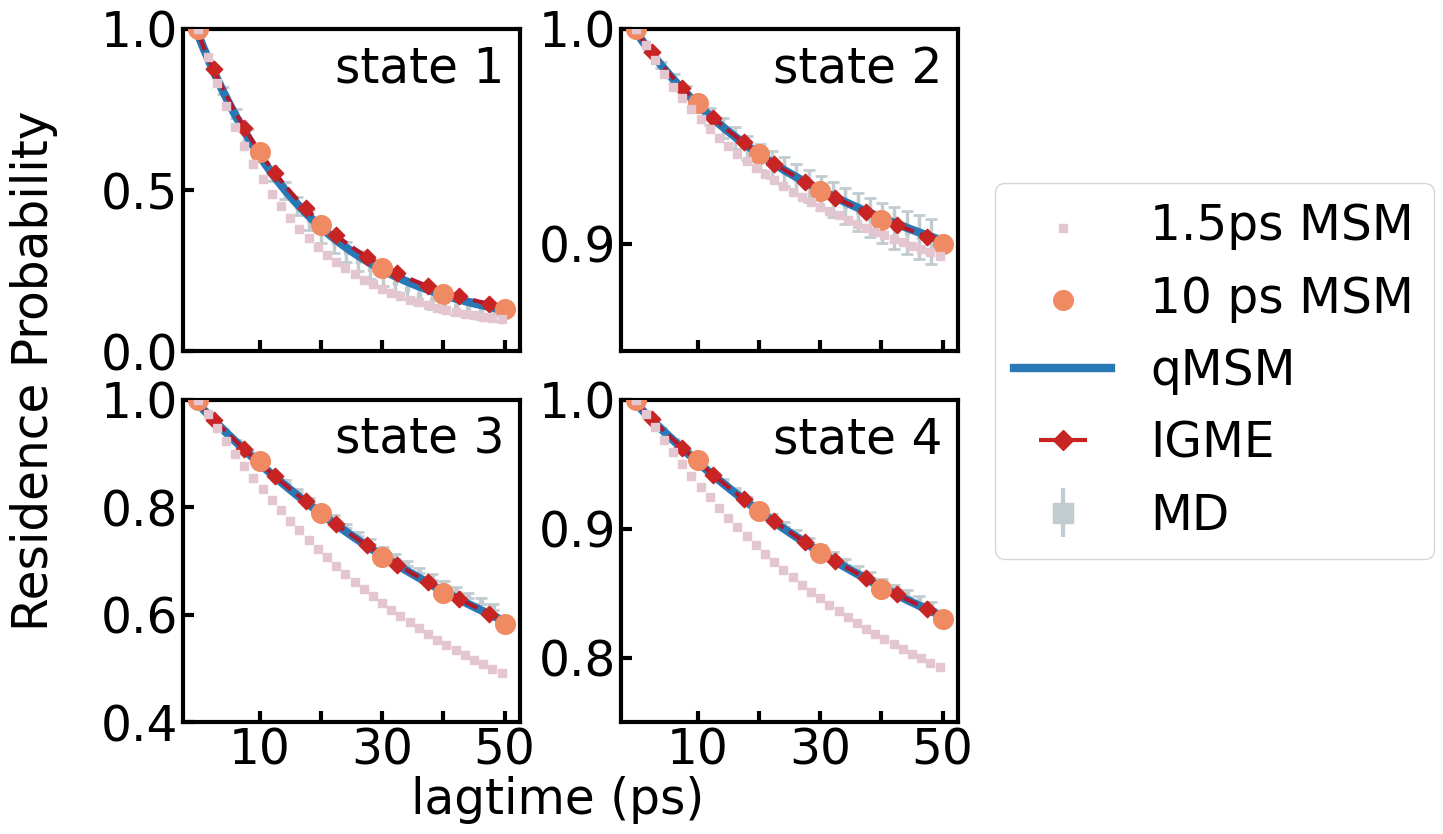

In [ ]:
# @title CK test
length = 500
lt = np.arange(1,length+1) * delta_t
n_state = 4
plt.rcParams['font.size'] = 35
bottom = [0.02, 0.85, 0.4, 0.75]

TPM_mean = np.mean(bootstrap_TPM, axis=0)
TPM_std = np.std(bootstrap_TPM, axis=0)
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True)

for i in range(n_state):
    ax = axes[i//2, i-(i//2)*2]
#     ax.fill_between(lt, TPM_mean[:length,i,i]-TPM_std[:length,i,i],
#                     TPM_mean[:length,i,i]+TPM_std[:length,i,i], color='#fff2df', zorder=0)
    ax.errorbar(x=lt[:length:20], y=TPM_mean[:length:20,i,i], yerr=TPM_std[:length:20,i,i],
                fmt='s', capsize=4, capthick=2, elinewidth=2.5, markersize=3,
                ecolor='#c2ccd0', color='#c2ccd0',
                zorder=0)

    ax.set_ylim(bottom[i],1.0)
    ax.text(50, 0.95+0.05*bottom[i], 'state %d'%(i+1), ha='right',va='top')
    ax.tick_params(axis='both', direction='in', width=3, length=8)
    ax.set_xticks(ticks=[10,20,30,40,50], labels=[10,'',30,'',50])
    for spine in ax.spines.values():
        spine.set_linewidth(3)

axes[0, 0].set_ylim(0,1.0)
axes[0, 1].set_ylim(0.85,1.0)
axes[1, 0].set_ylim(0.4,1.0)
axes[1, 1].set_ylim(0.75,1.0)

plt.scatter([], [], c='#e4c6d0', s=40, marker='s', label='1.5ps MSM')
plt.scatter([], [], c='#ef8a62', s=200, label='10 ps MSM')
plt.plot([], [], label='qMSM', color='#2878B5', linewidth=6)
plt.errorbar([], [], xerr=[], color='#C82423', label='IGME', fmt='D',
             markersize=10, elinewidth=3, capsize=3)
plt.errorbar([], [], yerr=[], color='#c2ccd0', label='MD', fmt='s',
             markersize=15, elinewidth=3, capsize=3)
fig.text(0.5, 0.05, 'lagtime (ps)', ha='center', va='top')
fig.text(0, 0.5, "Residence Probability", ha='right', va='center', rotation=90)
fig.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.subplots_adjust(wspace=0.3, hspace=0.15)
plt.show()